In [1]:
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()     # এখানে kaggle.json ফাইল upload করবেন
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d mdnafsunkabir/ecgdata
!unzip ecgdata.zip -d ecg_data


Dataset URL: https://www.kaggle.com/datasets/mdnafsunkabir/ecgdata
License(s): unknown
 88% 725M/826M [00:04<00:02, 45.3MB/s]
100% 826M/826M [00:04<00:00, 207MB/s] 
Archive:  ecgdata.zip
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(1).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(10).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(100).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(101).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(102).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(103).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(104).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(105).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(106).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(107).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB(108).jpg  
  inflating: ecg_data/ECG_DATA/test/Abnormal heartbeat/HB

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.utils import class_weight
import numpy as np

# -----------------------------
# DATA PREPROCESSING
# -----------------------------
IMG_SIZE = (224, 224)
BATCH = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ecg_data/ECG_DATA/train",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "ecg_data/ECG_DATA/test",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

class_names = train_ds.class_names
print(class_names)

# Convert to value batches for class weight
y_train = np.concatenate([y for x, y in train_ds], axis=0)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i : weights[i] for i in range(len(weights))}
print("Class Weights =", class_weights)

# -----------------------------
# RESNET50 TRANSFER LEARNING
# -----------------------------
base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# ❗ প্রথম ধাপে freeze
for layer in base.layers:
    layer.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base,

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# -----------------------------
# TRAIN FIRST PHASE
# -----------------------------
history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    class_weight=class_weights,
    epochs=15
)

# -----------------------------
# UNFREEZE LAST 20 LAYERS FOR FINE TUNE
# -----------------------------
for layer in base.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # smaller LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_ds,
    validation_data=test_ds,
    class_weight=class_weights,
    epochs=40
)


Found 3023 files belonging to 4 classes.
Found 928 files belonging to 4 classes.
['Abnormal heartbeat', 'History of MI', 'Myocardial Infarction', 'Normal']
Class Weights = {0: np.float64(1.0811874105865522), 1: np.float64(1.4646317829457365), 2: np.float64(0.7905334728033473), 3: np.float64(0.8870305164319249)}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 69s 592ms/step - accuracy: 0.2509 - loss: 1.5735 - val_accuracy: 0.2188 - val_loss: 1.3759
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 62s 653ms/step - accuracy: 0.2462 - loss: 1.4458 - val_accuracy: 0.3168 - val_loss: 1.3679
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 54s 573ms/step - accuracy: 0.3010 - loss: 1.3807 - val_accuracy: 0.3114 - val_loss: 1.3615
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 580ms/step - accuracy: 0.3445 - loss: 1.3548 - val_accuracy: 0.2769 - val_loss: 1.3531
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 63s 663ms/step - accuracy: 0.3470 - loss: 1.3401 - val_accuracy: 0.3513 - val_loss: 1.3334
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 63s 668ms/step - accuracy: 0.3716 - loss: 1.3206 - val_accuracy: 0.3718 - val_loss: 1.3232
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 83s 678ms/step - accuracy: 0.3773 - loss: 1.3160 - val_accuracy: 0.3739 - val_loss: 1.3347
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 59s 624ms/step - accuracy: 0.3804 - loss: 1.3082 - val_accu

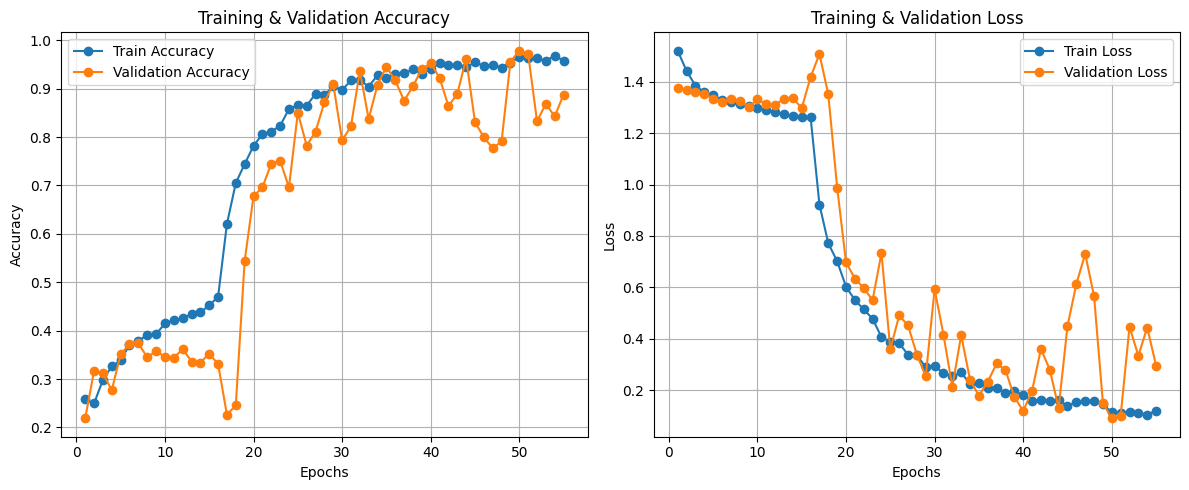

In [35]:
import matplotlib.pyplot as plt

# -----------------------------
# Combine Histories
# -----------------------------
# Concatenate the accuracy and loss from both phases
acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']

loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

# Total epochs
epochs = range(1, len(acc) + 1)

# -----------------------------
# Plot Accuracy
# -----------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -----------------------------
# Plot Loss
# -----------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [36]:
# -----------------------------
# FINAL TRAINING ACCURACY
# -----------------------------
# The last epoch of history2 contains final training and validation metrics
final_train_acc = history2.history['accuracy'][-1]
final_val_acc = history2.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")

# -----------------------------
# EVALUATE ON TEST SET
# -----------------------------
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")


Final Training Accuracy: 95.80%
Final Validation Accuracy: 88.79%
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 513ms/step - accuracy: 0.9643 - loss: 0.1047
Test Accuracy: 89.01%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

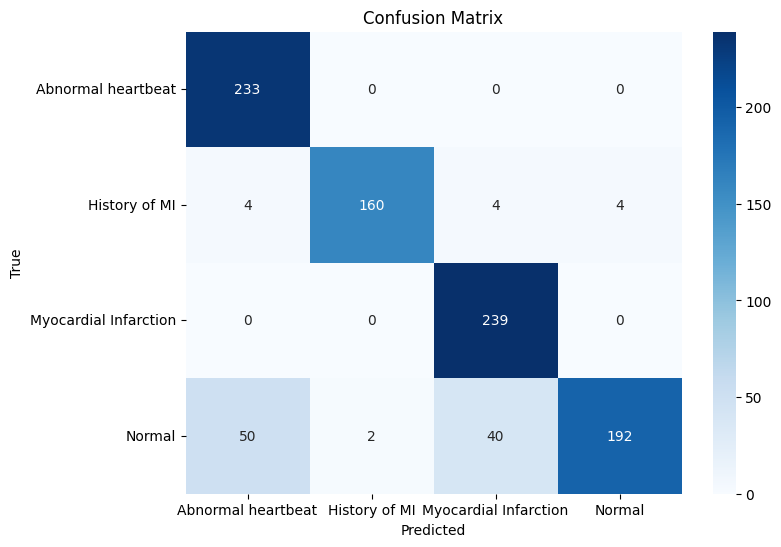

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on test images
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = []

for batch, label in test_ds:
    pred = model.predict(batch)
    y_pred.extend(np.argmax(pred, axis=1))

y_pred = np.array(y_pred)

# -------------------------------
# 📌 Overall Test Accuracy
# -------------------------------
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy =", test_accuracy)

# -------------------------------
# 📌 Classification Report
# (Precision, Recall, F1-score)
# -------------------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# -------------------------------
# 📌 Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [39]:
# Save model in native Keras format
model.save("ecg_resnet50_model.keras")
print("Model saved in native Keras format!")


Model saved in native Keras format!


In [40]:
from tensorflow.keras.models import load_model

# Load native Keras model
model = load_model("ecg_resnet50_model.keras")
print("Model loaded successfully!")

# Test accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model loaded successfully!
29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 446ms/step - accuracy: 0.9643 - loss: 0.1047
Test Accuracy: 89.01%
